In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print('TensorFlow:', tf.__version__)

TensorFlow: 2.2.0-rc2


In [29]:
shapes_dataset_tfrecords_path = '../tutorials/data/shapes_dataset_tfrecords'
train_tfrecords_pattern = shapes_dataset_tfrecords_path + '/train*'

In [30]:
train_tfrecords = tf.data.Dataset.list_files(train_tfrecords_pattern)

for x in train_tfrecords:
    print(x)

tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0007.tfrecord', shape=(), dtype=string)
tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0005.tfrecord', shape=(), dtype=string)
tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0004.tfrecord', shape=(), dtype=string)
tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0001.tfrecord', shape=(), dtype=string)
tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0002.tfrecord', shape=(), dtype=string)
tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0006.tfrecord', shape=(), dtype=string)
tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0008.tfrecord', shape=(), dtype=string)
tf.Tensor(b'../tutorials/data/shapes_dataset_tfrecords/train_0003.tfrecord', shape=(), dtype=string)


In [31]:
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'xmins': tf.io.VarLenFeature(tf.float32),
        'ymins': tf.io.VarLenFeature(tf.float32),
        'xmaxs': tf.io.VarLenFeature(tf.float32),
        'ymaxs': tf.io.VarLenFeature(tf.float32),
        'classes': tf.io.VarLenFeature(tf.int64),
    }

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_image(parsed_example['image'], channels=3)
    image.set_shape([None, None, 3])
    boxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs']),
    ], axis=-1)
    classes = tf.sparse.to_dense(parsed_example['classes'])
    return image, boxes, classes


def build_tfrecord_dataset(tfrecords):
    dataset = tfrecords.interleave(
        tf.data.TFRecordDataset,
        cycle_length=4,
        block_length=16,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_example,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [32]:
dataset = build_tfrecord_dataset(train_tfrecords)
tf.data.experimental.get_structure(dataset)

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [33]:
def imshow(image):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)


def draw_boxes_cv2(image, boxes, categories):
    boxes = np.array(boxes, dtype=np.int32)
    for _box, _cls in zip(boxes, categories):
        text = _cls
        char_len = len(text) * 9
        text_orig = (_box[0] + 5, _box[1] - 6)
        text_bg_xy1 = (_box[0], _box[1] - 20)
        text_bg_xy2 = (_box[0] + char_len, _box[1])
        image = cv2.rectangle(image, text_bg_xy1, text_bg_xy2, [255, 252, 150],
                              -1)
        image = cv2.putText(image,
                            text,
                            text_orig,
                            cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            .6, [0, 0, 0],
                            5,
                            lineType=cv2.LINE_AA)
        img = cv2.putText(image,
                          text,
                          text_orig,
                          cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          .6, [255, 255, 255],
                          1,
                          lineType=cv2.LINE_AA)
        img = cv2.rectangle(image, (_box[0], _box[1]), (_box[2], _box[3]),
                            [30, 15, 30], 2)
    return img

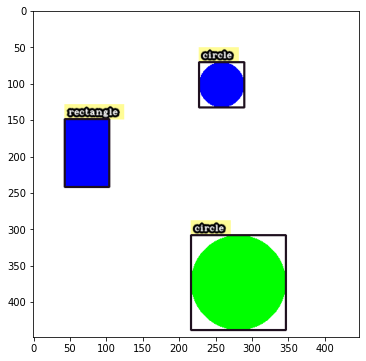

In [37]:
class_map = {0: 'circle', 1: 'rectangle'}

for image, boxes, class_ids in dataset.take(1):
    classes = [class_map[int(x)] for x in class_ids.numpy()]
    viz_image = draw_boxes_cv2(image.numpy(), boxes.numpy(), classes)
    imshow(viz_image)

In [38]:
def random_flip_data(image, boxes, w):
    w = tf.cast(tf.shape(image)[1], dtype=tf.float32)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [w - boxes[:, 2],
             boxes[:, 1],
             w - boxes[:, 0],
             boxes[:, 3]],
            axis=-1)
    return image, boxes

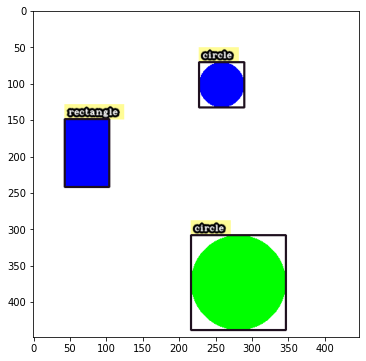

In [39]:
classes = [class_map[int(x)] for x in class_ids.numpy()]
image, boxes = random_flip_data(image, boxes, 448)
viz_image = draw_boxes_cv2(image.numpy(), boxes.numpy(), classes)
imshow(viz_image)